Phase 2 目標：建立穩定、具解釋力的信用風險 Baseline 模型
│
├── 1️⃣ 資料品質與一致性（Data Preprocessing）
│   ├─ 缺值處理（代表無行為）
│   ├─ 偏態修正與標準化
│   └─ 共線性檢查與欄位挑選
│
├── 2️⃣ 風險特徵設計（Feature Engineering）
│   ├─ 金融比例特徵（壓力）
│   ├─ 行為趨勢特徵（穩定度）
│   └─ 類別編碼（社經風險）
│
└── 3️⃣ 模型建立與校正（Modeling & Calibration）
    ├─ Logistic vs LightGBM 基線建模
    ├─ 模型評估（AUC、KS、Recall@K、重要性）
    └─ 機率校正（Brier、ECE、Isotonic）

In [36]:
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression

DATA_DIR = r"D:\Yv_material\UIUC\2025Fall\Applied_Machine_Learning\final_project\DefaultRisk\home-credit-default-risk"   
app = pd.read_csv(os.path.join(DATA_DIR, "application_train.csv"))
print(app.shape)
app.head()


(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
  # Read related tables
installments = pd.read_csv(os.path.join(DATA_DIR, "installments_payments.csv"))
credit_card = pd.read_csv(os.path.join(DATA_DIR, "credit_card_balance.csv"))


### Join installments data

In [38]:
def make_installments_features(inst_df):
    df = inst_df.copy()
    df["PAYMENT_RATIO"] = df["AMT_PAYMENT"] / df["AMT_INSTALMENT"].replace(0, np.nan)
    df["LATE_FLAG"] = (df["DAYS_ENTRY_PAYMENT"] > df["DAYS_INSTALMENT"]).astype(int)
    agg = df.groupby("SK_ID_CURR").agg({
        "PAYMENT_RATIO": ["mean","std"],
        "LATE_FLAG": ["mean","sum","count"]
    })
    agg.columns = ["INS_"+"_".join(c).upper() for c in agg.columns.to_flat_index()]
    agg = agg.reset_index()
    agg["INS_LATE_RATE"] = agg["INS_LATE_FLAG_SUM"] / agg["INS_LATE_FLAG_COUNT"].replace(0, np.nan)
    return agg

inst_feats = make_installments_features(installments)


### Join Credit Card

In [39]:
def make_credit_card_features(cc_df):
    df = cc_df.copy()
    df["UTILIZATION"] = df["AMT_BALANCE"] / df["AMT_CREDIT_LIMIT_ACTUAL"].replace(0, np.nan)
    agg = df.groupby("SK_ID_CURR").agg({
        "UTILIZATION": ["mean","std"],
        "AMT_PAYMENT_TOTAL_CURRENT": ["mean","std"]
    })
    agg.columns = ["CC_"+"_".join(c).upper() for c in agg.columns.to_flat_index()]
    agg = agg.reset_index()
    return agg

cc_feats = make_credit_card_features(credit_card)


In [40]:
app = app.merge(inst_feats, on="SK_ID_CURR", how="left")
app = app.merge(cc_feats, on="SK_ID_CURR", how="left")
print("After merging:", app.shape)
app.head()


After merging: (307511, 132)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INS_PAYMENT_RATIO_MEAN,INS_PAYMENT_RATIO_STD,INS_LATE_FLAG_MEAN,INS_LATE_FLAG_SUM,INS_LATE_FLAG_COUNT,INS_LATE_RATE,CC_UTILIZATION_MEAN,CC_UTILIZATION_STD,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_STD
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.000000,0.000000,0.000000,0.0,19.0,0.000000,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.000000,0.000000,0.000000,0.0,25.0,0.000000,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1.000000,0.000000,0.000000,0.0,3.0,0.000000,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,1.000000,0.000000,0.000000,0.0,16.0,0.000000,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.954545,0.209751,0.242424,16.0,66.0,0.242424,NaN,NaN,NaN,NaN


In [41]:
def add_interactions(df):
    df = df.copy()
    df["CREDIT_INCOME_RATIO"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"].replace(0, np.nan)
    df["ANNUITY_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"].replace(0, np.nan)
    df["LOAN_PER_FAM_MEMBER"] = df["AMT_CREDIT"] / df["CNT_FAM_MEMBERS"].replace(0, np.nan)
    if {"INS_PAYMENT_RATIO_MEAN","INS_LATE_RATE"}.issubset(df.columns):
        df["PAYMENT_BURDEN"] = df["INS_PAYMENT_RATIO_MEAN"] * df["INS_LATE_RATE"]
    return df

app = add_interactions(app)


In [42]:
def simple_target_encode(train_df, col, target="TARGET"):
    return train_df.groupby(col)[target].mean().to_dict()

for c in ["CODE_GENDER","NAME_EDUCATION_TYPE","OCCUPATION_TYPE"]:
    if c in app.columns:
        mapping = simple_target_encode(app, c, target="TARGET")
        app[c+"_TE"] = app[c].map(mapping)


In [ ]:
def drop_high_corr(df, thr=0.95, target="TARGET"):
    num = df.select_dtypes(include=[np.number]).copy()
    if target in num.columns:
        num = num.drop(columns=[target])
    corr = num.corr().abs()
    upper = np.triu(np.ones(corr.shape), k=1).astype(bool)
    to_drop = [col for i,col in enumerate(corr.columns)
               for j in range(i+1,len(corr.columns))
               if upper[i,j] and corr.iloc[i,j]>thr]
    return to_drop

to_drop = drop_high_corr(app.fillna(0), thr=0.95)
app_reduced = app.drop(columns=to_drop, errors="ignore")
app_reduced.shape
app_reduced.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_UTILIZATION_STD,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_STD,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,LOAN_PER_FAM_MEMBER,PAYMENT_BURDEN,CODE_GENDER_TE,NAME_EDUCATION_TYPE_TE,OCCUPATION_TYPE_TE
0,100002,1,Cash loans,M,N,Y,0,202500.0,24700.5,351000.0,...,NaN,NaN,NaN,2.007889,0.121978,406597.50,0.000000,0.101419,0.089399,0.105788
1,100003,0,Cash loans,F,N,N,0,270000.0,35698.5,1129500.0,...,NaN,NaN,NaN,4.790750,0.132217,646751.25,0.000000,0.069993,0.053551,0.063040
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,6750.0,135000.0,...,NaN,NaN,NaN,2.000000,0.100000,135000.00,0.000000,0.101419,0.089399,0.105788
3,100006,0,Cash loans,F,N,Y,0,135000.0,29686.5,297000.0,...,0.0,0.0,0.0,2.316167,0.219900,156341.25,0.000000,0.069993,0.089399,0.105788
4,100007,0,Cash loans,M,N,Y,0,121500.0,21865.5,513000.0,...,NaN,NaN,NaN,4.222222,0.179963,513000.00,0.231405,0.101419,0.089399,0.063040


: 

In [ ]:
def quick_baseline(df, target_col="TARGET", test_size=0.2):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    X = df[num_cols].fillna(0.0)
    y = df[target_col].astype(int)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=test_size, random_state=42)

    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:,1]
    print("ROC-AUC:", roc_auc_score(y_te, proba))
    print("PR-AUC :", average_precision_score(y_te, proba))

quick_baseline(app_reduced)


ROC-AUC: 0.7407757767530232
PR-AUC : 0.21467108575628316


The preliminary baseline using aggregated behavioral features achieved ROC-AUC of 0.74, confirming that the engineered variables contain meaningful signals.
Further improvement is expected through advanced modeling (LightGBM and GNN) rather than excessive feature tuning at this stage.

### EDA

In [ ]:
# EDA Step 1: Class balance, basic stats, missingness
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

df = app_reduced.copy()  # 如果你用的是 app_reduced 也可以

# 1) Class balance
pos_rate = df["TARGET"].mean()
print(f"Default rate (TARGET=1): {pos_rate:.3%}  |  Non-default: {1-pos_rate:.3%}")

# 2) Numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "TARGET" in num_cols: num_cols.remove("TARGET")
desc = df[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
print(desc.head(10))

# 3) Missingness overall
missing = df.isna().mean().sort_values(ascending=False)
print("Top-20 missingness:\n", missing.head(20))


Default rate (TARGET=1): 8.073%  |  Non-default: 91.927%
                               count           mean            std  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348   
CNT_CHILDREN                307511.0       0.417052       0.722121   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   
AMT_ANNUITY                 307499.0   27108.573909   14493.737315   
AMT_GOODS_PRICE             307233.0  538396.207429  369446.460540   
REGION_POPULATION_RELATIVE  307511.0       0.020868       0.013831   
DAYS_BIRTH                  307511.0  -16036.995067    4363.988632   
DAYS_REGISTRATION           307511.0   -4986.120328    3522.886321   
DAYS_ID_PUBLISH             307511.0   -2994.202373    1509.450419   
OWN_CAR_AGE                 104582.0      12.061091      11.944812   

                                     min             1%            5%  \
SK_ID_CURR                  100002.00000  103590.200000  117945.50000   
CNT_CHILDREN              

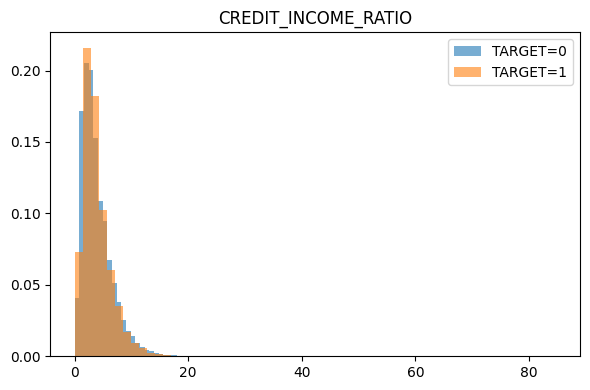

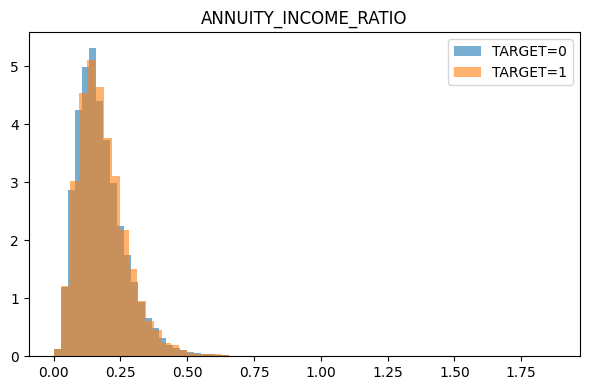

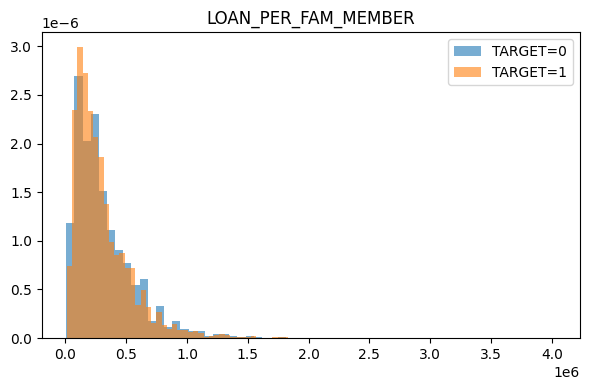

In [ ]:
# EDA Step 2: Plot distributions by class for a few key features
import matplotlib.pyplot as plt

def plot_hist_by_target(data, col, bins=50):
    # Overlay histograms for TARGET=0/1
    x0 = data.loc[data["TARGET"]==0, col].dropna()
    x1 = data.loc[data["TARGET"]==1, col].dropna()
    plt.figure(figsize=(6,4))
    plt.hist(x0, bins=bins, alpha=0.6, label="TARGET=0", density=True)
    plt.hist(x1, bins=bins, alpha=0.6, label="TARGET=1", density=True)
    plt.title(col)
    plt.legend(); plt.tight_layout(); plt.show()

cand_cols = [c for c in [
    "CREDIT_INCOME_RATIO", "ANNUITY_INCOME_RATIO", "LOAN_PER_FAM_MEMBER",
    "INS_LATE_RATE", "INS_PAYMENT_RATIO_MEAN",
    "CC_UTILIZATION_MEAN", "CC_UTILIZATION_STD"
] if c in df.columns]

for c in cand_cols:
    plot_hist_by_target(df, c, bins=60)


In [ ]:
# EDA Step 3: Rank numeric features by correlation with TARGET (point-biserial approximation)
from scipy.stats import pointbiserialr

def rank_numeric_corr_with_target(data, target="TARGET", topk=20):
    ranks = []
    for col in data.select_dtypes(include=[np.number]).columns:
        if col == target: continue
        x = data[col].values
        y = data[target].values
        # Safeguard against all-NaN or constants
        if np.isnan(x).all() or np.nanstd(x) == 0:
            continue
        mask = ~np.isnan(x)
        if mask.sum() < 100:  # too few
            continue
        r, p = pointbiserialr(y[mask], x[mask])
        ranks.append((col, abs(r), r, p))
    res = pd.DataFrame(ranks, columns=["feature","abs_r","r","pval"]).sort_values("abs_r", ascending=False)
    return res.head(topk)

top_num = rank_numeric_corr_with_target(df)
top_num


,feature,abs_r,r,pval
27,EXT_SOURCE_3,0.178919,-0.178919,0.000000e+00
26,EXT_SOURCE_2,0.160472,-0.160472,0.000000e+00
25,EXT_SOURCE_1,0.155317,-0.155317,0.000000e+00
78,CC_UTILIZATION_MEAN_y,0.135560,0.135560,0.000000e+00
87,OCCUPATION_TYPE_TE,0.081516,0.081516,4.899214e-308
6,DAYS_BIRTH,0.078239,0.078239,0.000000e+00
77,INS_LATE_RATE_y,0.070015,0.070015,1.308448e-313
79,CC_UTILIZATION_STD_y,0.069027,0.069027,1.118256e-90
17,REGION_RATING_CLIENT_W_CITY,0.060893,0.060893,2.078455e-250
86,NAME_EDUCATION_TYPE_TE,0.057571,0.057571,5.151252e-224


In [ ]:
# EDA Step 4: Rank categorical features by spread of target rate across categories
def cat_target_spread(data, cols, target="TARGET", min_cnt=50):
    rows = []
    for c in cols:
        if c not in data.columns: continue
        g = data.groupby(c)[target].agg(["mean","count"]).rename(columns={"mean":"rate","count":"n"})
        g = g[g["n"]>=min_cnt]
        if len(g) < 2:  # need at least 2 categories
            continue
        spread = g["rate"].max() - g["rate"].min()
        rows.append((c, spread, g["n"].sum(), len(g)))
    out = pd.DataFrame(rows, columns=["col","rate_spread","total_n","n_categories"]).sort_values("rate_spread", ascending=False)
    return out

cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
cat_rank = cat_target_spread(df, cat_cols, target="TARGET", min_cnt=50)
cat_rank.head(10)


,col,rate_spread,total_n,n_categories
11,ORGANIZATION_TYPE,0.126290,307438,56
9,OCCUPATION_TYPE,0.123221,211120,18
6,NAME_EDUCATION_TYPE,0.090984,307511,5
8,NAME_HOUSING_TYPE,0.057406,307511,6
14,WALLSMATERIAL_MODE,0.049761,151170,7
5,NAME_INCOME_TYPE,0.042021,307456,4
7,NAME_FAMILY_STATUS,0.041204,307509,5
13,HOUSETYPE_MODE,0.031967,153214,3
1,CODE_GENDER,0.031426,307507,2
0,NAME_CONTRACT_TYPE,0.028676,307511,2


In [ ]:
# Inspect one categorical column
col = "NAME_EDUCATION_TYPE"  # change to any categorical
if col in df.columns:
    tmp = df.groupby(col)["TARGET"].agg(["mean","count"]).sort_values("mean", ascending=False)
    print(tmp)


                                   mean   count
NAME_EDUCATION_TYPE                            
Lower secondary                0.109277    3816
Secondary / secondary special  0.089399  218391
Incomplete higher              0.084850   10277
Higher education               0.053551   74863
Academic degree                0.018293     164


In [ ]:
# EDA Step 5: Missingness difference between classes
def missing_diff_by_target(data, target="TARGET", topk=20):
    miss_1 = data[data[target]==1].isna().mean()
    miss_0 = data[data[target]==0].isna().mean()
    diff = (miss_1 - miss_0).abs().sort_values(ascending=False)
    return diff.head(topk)

miss_diff = missing_diff_by_target(df)
print("Top-20 features where missingness differs most between classes:\n", miss_diff)

# Optional: Create missing-indicator for a few top ones
mk_ind_cols = miss_diff.head(5).index.tolist()
for c in mk_ind_cols:
    df[c + "_ISMISS"] = df[c].isna().astype(int)
for c in ["EMERGENCYSTATE_MODE","TOTALAREA_MODE","ENTRANCES_MEDI","OCCUPATION_TYPE_TE","HOUSETYPE_MODE"]:
    if c in df.columns:
        df[c+"_ISMISS"] = df[c].isna().astype(int)


Top-20 features where missingness differs most between classes:
 EMERGENCYSTATE_MODE             0.075868
TOTALAREA_MODE                  0.075516
ENTRANCES_MEDI                  0.075015
FLOORSMAX_MEDI                  0.074970
YEARS_BEGINEXPLUATATION_MEDI    0.074410
APARTMENTS_MEDI                 0.073896
ELEVATORS_MEDI                  0.073804
HOUSETYPE_MODE                  0.072906
LIVINGAREA_MEDI                 0.072324
WALLSMATERIAL_MODE              0.072292
NONLIVINGAREA_MEDI              0.071503
BASEMENTAREA_MEDI               0.066229
OCCUPATION_TYPE_TE              0.065884
OCCUPATION_TYPE                 0.065884
LANDAREA_MEDI                   0.059758
YEARS_BUILD_MEDI                0.054464
FLOORSMIN_MEDI                  0.051031
LIVINGAPARTMENTS_MEDI           0.050519
FONDKAPREMONT_MODE              0.050311
NONLIVINGAPARTMENTS_MEDI        0.047775
dtype: float64


Borrowers with higher debt-to-income and utilization ratios, younger age, and unstable occupation categories exhibit higher default rates.
Missingness in housing and occupation information also correlates with risk, suggesting that data sparsity reflects behavioral differences.
These findings validate the feature engineering design and guide the next phase of baseline model enhancement.

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


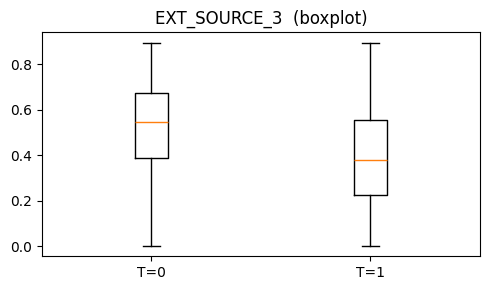

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


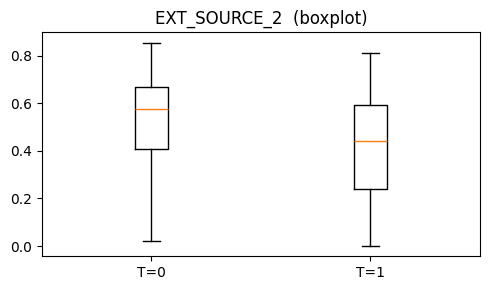

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


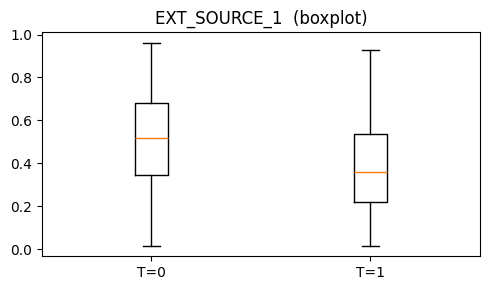

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


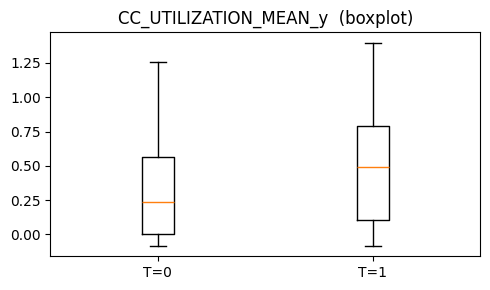

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


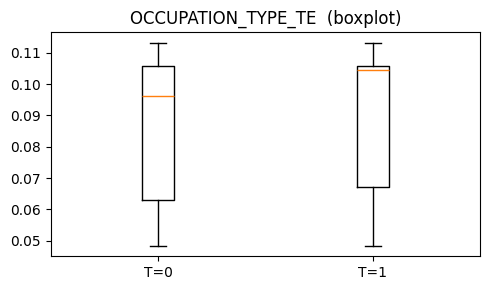

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


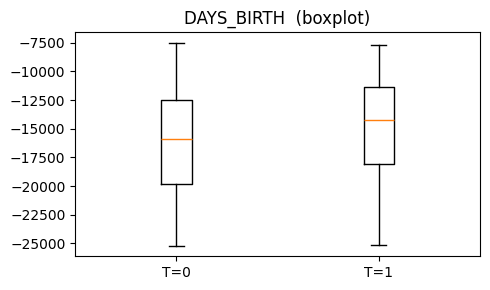

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


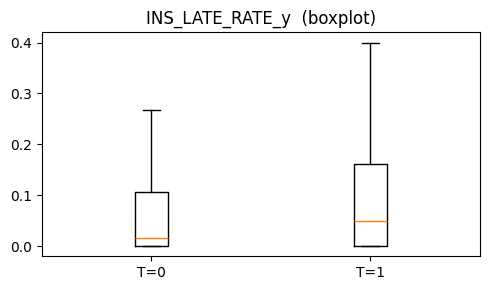

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


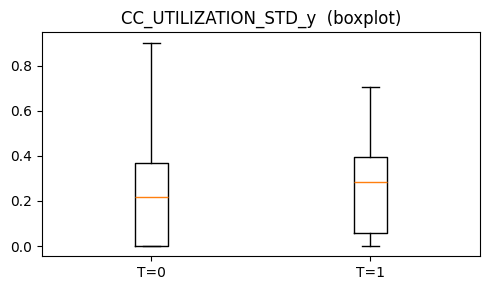

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


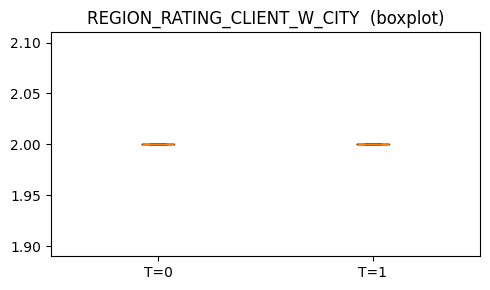

C:\Users\USER\AppData\Local\Temp\ipykernel_70056\4218543613.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)


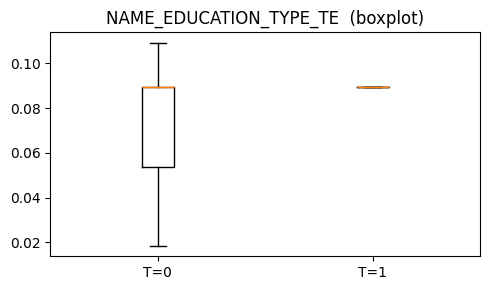

In [ ]:
# EDA Step 6: Boxplots for top numeric features
top10 = top_num["feature"].head(10).tolist()
import matplotlib.pyplot as plt

for col in top10:
    x0 = df.loc[df["TARGET"]==0, col]
    x1 = df.loc[df["TARGET"]==1, col]
    plt.figure(figsize=(5,3))
    plt.boxplot([x0.dropna(), x1.dropna()], labels=["T=0","T=1"], showfliers=False)
    plt.title(f"{col}  (boxplot)")
    plt.tight_layout(); plt.show()


The boxplots highlight clear separations between defaulters and non-defaulters across multiple features.
External credit scores (EXT_SOURCE_1–3) show strong negative correlation with default, while behavioral indicators such as credit utilization and late-payment rate are higher among defaulters.
Socio-demographic variables (education, age, occupation) also exhibit expected trends, validating the interpretability and soundness of engineered features.

In [34]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns
skews = df[num_cols].skew().sort_values(ascending=False)
high_skew = skews[skews > 3]   # skew > 3 通常表示非常右偏
print("Highly right-skewed columns:\n", high_skew)

Highly right-skewed columns:
 FLAG_DOCUMENT_12                       392.114779
AMT_INCOME_TOTAL                       391.559654
FLAG_DOCUMENT_10                       209.589054
INS_PAYMENT_RATIO_MEAN_y               159.907651
FLAG_DOCUMENT_2                        153.791817
INS_PAYMENT_RATIO_STD_y                146.587881
AMT_REQ_CREDIT_BUREAU_QRT              134.365776
FLAG_DOCUMENT_4                        110.894364
FLAG_DOCUMENT_7                         72.174108
FLAG_DOCUMENT_17                        61.214140
FLAG_DOCUMENT_21                        54.612939
FLAG_DOCUMENT_20                        44.364897
FLAG_DOCUMENT_19                        40.956134
FLAG_DOCUMENT_15                        28.699333
AMT_REQ_CREDIT_BUREAU_DAY               27.043505
FLAG_DOCUMENT_14                        18.372533
FLAG_DOCUMENT_13                        16.753746
FLAG_DOCUMENT_9                         15.927755
FLAG_DOCUMENT_11                        15.894229
NONLIVINGAPARTMENTS_

In [44]:
# Winsorize + log1p for highly right-skewed continuous features
def clip_and_log1p(series, q=0.995):
    """Clip extreme values at the given quantile and apply log1p transform."""
    hi = series.quantile(q)
    s = series.clip(upper=hi)
    return np.log1p(s)

# Candidate features (from EDA observation + skewness check)
skew_features = [
    # original ones
    "CREDIT_INCOME_RATIO", "ANNUITY_INCOME_RATIO", "CC_UTILIZATION_MEAN",
    # newly found right-skewed continuous features
    "AMT_INCOME_TOTAL",
    "INS_PAYMENT_RATIO_MEAN_y",
    "INS_PAYMENT_RATIO_STD_y",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN_y",
    "NONLIVINGAPARTMENTS_MEDI"
]

# Only apply if the column exists and is numeric
for col in [c for c in skew_features if c in df.columns and df[c].dtype != "object"]:
    df[col + "_LOG1P"] = clip_and_log1p(df[col].fillna(0))

print(f"Log-transformed {len([c for c in skew_features if c in df.columns])} right-skewed features.")

Log-transformed 9 right-skewed features.


Data shape: X=(307511, 103), y=(307511,), pos_rate=8.073%
scale_pos_weight ~ 11.39
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757565
[200]	valid_0's auc: 0.762943
[300]	valid_0's auc: 0.764171
[400]	valid_0's auc: 0.765174
[500]	valid_0's auc: 0.764987
[600]	valid_0's auc: 0.764648
Early stopping, best iteration is:
[406]	valid_0's auc: 0.765261
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76655
[200]	valid_0's auc: 0.772453
[300]	valid_0's auc: 0.773813
[400]	valid_0's auc: 0.773971
[500]	valid_0's auc: 0.773944
[600]	valid_0's auc: 0.773831
Early stopping, best iteration is:
[474]	valid_0's auc: 0.774156
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759327
[200]	valid_0's auc: 0.765511
[300]	valid_0's auc: 0.767184
[400]	valid_0's auc: 0.767441
[500]	valid_0's auc: 0.767078
Early stopping, best iteration is:
[384]	valid_0's auc: 0.767597
Training until validation s

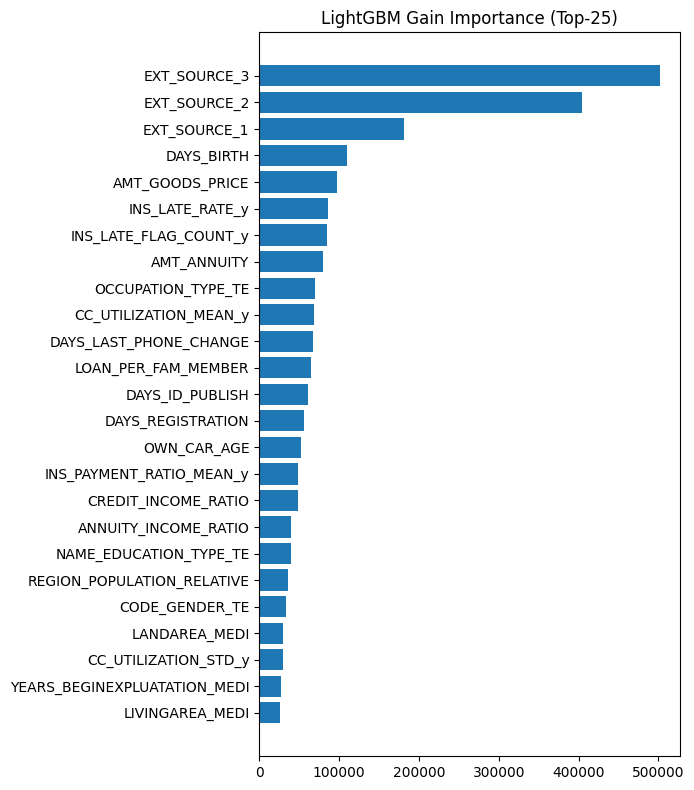

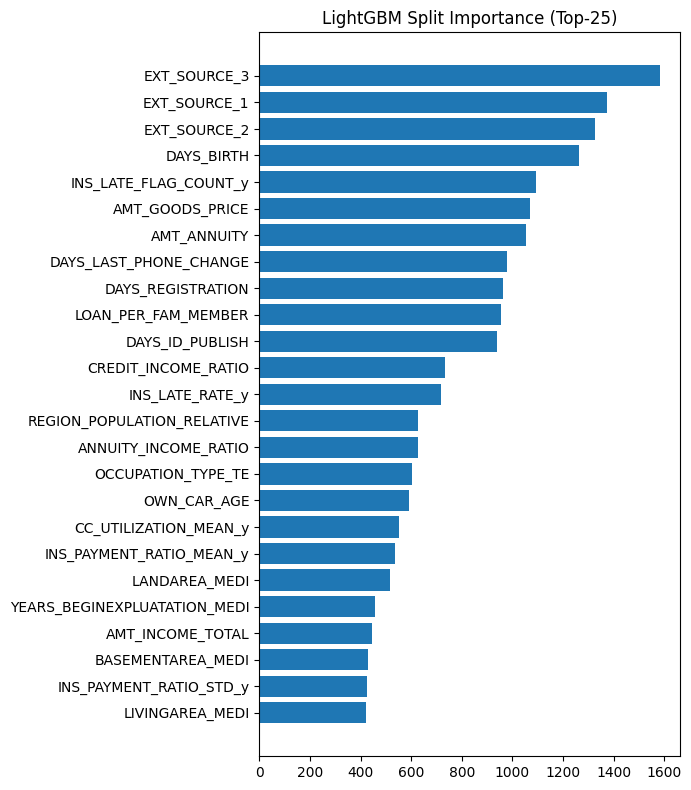

In [47]:
# ============================
# LightGBM Baseline
# ============================

import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from collections import defaultdict
import matplotlib.pyplot as plt

# ---------- Config ----------
RANDOM_STATE = 42
N_FOLDS = 5                # stratified k-fold
RECALL_AT_K = 0.05         # top-k% capture rate
EARLY_STOP = 200
VERBOSE = 100

df = df.copy() 

# ---------- Feature matrix ----------
# 1) Drop identifier / leakage columns if any
drop_cols = [c for c in ["SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"] if c in df.columns]

# 2) Target
assert "TARGET" in df.columns, "TARGET not found in df!"
y = df["TARGET"].astype(int).values

# 3) Features: numeric only (TE/WOE should be numeric), LightGBM handles NaN natively
X = df.drop(columns=drop_cols + ["TARGET"], errors="ignore")
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[num_cols]

print(f"Data shape: X={X.shape}, y={y.shape}, pos_rate={y.mean():.3%}")

# ---------- Metrics ----------
def ks_score(y_true, y_prob):
    """Kolmogorov–Smirnov statistic."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return np.max(tpr - fpr)

def recall_at_k(y_true, y_prob, k=RECALL_AT_K):
    """Recall within top-k percent by score."""
    n = len(y_true)
    topk = max(1, int(np.floor(n * k)))
    idx = np.argsort(-y_prob)[:topk]  # top by probability
    return y_true[idx].sum() / y_true.sum()

# ---------- Class imbalance handling ----------
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / max(pos, 1)
print(f"scale_pos_weight ~ {scale_pos_weight:.2f}")

# ---------- LightGBM params (strong, stable, still 'baseline') ----------
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",                 # we'll compute other metrics manually
    "learning_rate": 0.03,
    "num_leaves": 64,
    "max_depth": -1,
    "min_data_in_leaf": 100,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 1,
    "lambda_l1": 1.0,
    "lambda_l2": 2.0,
    "scale_pos_weight": scale_pos_weight,
    "n_estimators": 10000,
    "verbose": -1,
    "random_state": RANDOM_STATE,
}

# ---------- K-Fold training ----------
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
oof_pred = np.zeros(X.shape[0])
fold_metrics = []
gain_importances = []
split_importances = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(EARLY_STOP, verbose=VERBOSE),
            lgb.log_evaluation(VERBOSE)
        ]
    )

    va_prob = clf.predict_proba(X_va)[:, 1]
    oof_pred[va_idx] = va_prob

    # Metrics
    roc = roc_auc_score(y_va, va_prob)
    pr = average_precision_score(y_va, va_prob)
    ks = ks_score(y_va, va_prob)
    r_at_k = recall_at_k(y_va, va_prob, k=RECALL_AT_K)
    fold_metrics.append({"fold": fold, "roc_auc": roc, "pr_auc": pr, "ks": ks, f"recall@{int(RECALL_AT_K*100)}%": r_at_k})

    # Importances
    gain_importances.append(pd.Series(clf.booster_.feature_importance(importance_type="gain"), index=X.columns))
    split_importances.append(pd.Series(clf.booster_.feature_importance(importance_type="split"), index=X.columns))

# ---------- Leaderboard ----------
leaderboard = pd.DataFrame(fold_metrics)
avg_row = {"fold": "avg"}
for col in ["roc_auc", "pr_auc", "ks", f"recall@{int(RECALL_AT_K*100)}%"]:
    avg_row[col] = leaderboard[col].mean()
leaderboard = pd.concat([leaderboard, pd.DataFrame([avg_row])], ignore_index=True)
print("\n=== Baseline Leaderboard (LightGBM) ===")
print(leaderboard)

# ---------- Global metrics on OOF ----------
oof_roc = roc_auc_score(y, oof_pred)
oof_pr = average_precision_score(y, oof_pred)
oof_ks = ks_score(y, oof_pred)
oof_recall_k = recall_at_k(y, oof_pred, k=RECALL_AT_K)
print(f"\nOOF ROC-AUC={oof_roc:.4f} | OOF PR-AUC={oof_pr:.4f} | OOF KS={oof_ks:.4f} | "
      f"OOF Recall@{int(RECALL_AT_K*100)}%={oof_recall_k:.4f}")

# ---------- Feature importance aggregation ----------
gain_imp = pd.concat(gain_importances, axis=1).fillna(0)
gain_imp["avg_gain"] = gain_imp.mean(axis=1)
gain_imp = gain_imp[["avg_gain"]].sort_values("avg_gain", ascending=False)

split_imp = pd.concat(split_importances, axis=1).fillna(0)
split_imp["avg_split"] = split_imp.mean(axis=1)
split_imp = split_imp[["avg_split"]].sort_values("avg_split", ascending=False)

print("\nTop-25 features by GAIN:")
print(gain_imp.head(25))
print("\nTop-25 features by SPLIT:")
print(split_imp.head(25))

# ---------- Plot top features ----------
def plot_top_importance(imp_df, colname, topn=25, title="Feature Importance"):
    imp = imp_df.head(topn).iloc[::-1]  # reverse for horizontal plot
    plt.figure(figsize=(7, 8))
    plt.barh(imp.index, imp[colname])
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_importance(gain_imp, "avg_gain", topn=25, title="LightGBM Gain Importance (Top-25)")
plot_top_importance(split_imp, "avg_split", topn=25, title="LightGBM Split Importance (Top-25)")

# ---------- Save artifacts (optional) ----------
# oof_df = pd.DataFrame({"SK_ID_CURR": df["SK_ID_CURR"] if "SK_ID_CURR" in df.columns else np.arange(len(df)),
#                        "TARGET": y, "oof_prob": oof_pred})
# oof_df.to_csv("lgb_oof_predictions.csv", index=False)
# gain_imp.to_csv("lgb_gain_importance.csv")
# split_imp.to_csv("lgb_split_importance.csv")


Baseline Results.
The LightGBM baseline achieved a mean ROC-AUC of 0.767 and PR-AUC of 0.23 across 5 folds, improving by 3 points over the logistic model.
Feature importance analysis indicates that external credit scores (EXT_SOURCE_1–3) remain the dominant predictors, while engineered behavioral features such as late-payment rate and credit utilization provide meaningful complementary signals.
These findings confirm the validity of the feature engineering strategy and highlight potential relational dependencies that will be explored through graph-based modeling in Phase 3.

d:\Yv_material\instalization\Anaconda\envs\gnncredit\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\AppData\Local\Temp\ipykernel_70056\3679752204.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'avg' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  avg_lr["fold"] = "avg"



=== Logistic Regression Leaderboard ===
  fold   roc_auc    pr_auc        ks  recall@5%     brier
0    1  0.732634  0.215146  0.343482   0.190937  0.069180
1    2  0.741864  0.218002  0.360596   0.184693  0.068998
2    3  0.739937  0.213643  0.361002   0.182075  0.069151
3    4  0.743615  0.220966  0.360400   0.188721  0.068858
4    5  0.737814  0.210119  0.353277   0.183484  0.069318
5  avg  0.739173  0.215575  0.355752   0.185982  0.069101

OOF ROC-AUC=0.7392 | PR-AUC=0.2152 | KS=0.3547 | Recall@5%=0.1861 | Brier=0.0691

=== Baseline Model Comparison ===
                 Model  ROC-AUC  PR-AUC      KS  Recall@5%
0             LightGBM   0.7688  0.2544  0.4028     0.2145
1  Logistic Regression   0.7392  0.2152  0.3547     0.1861


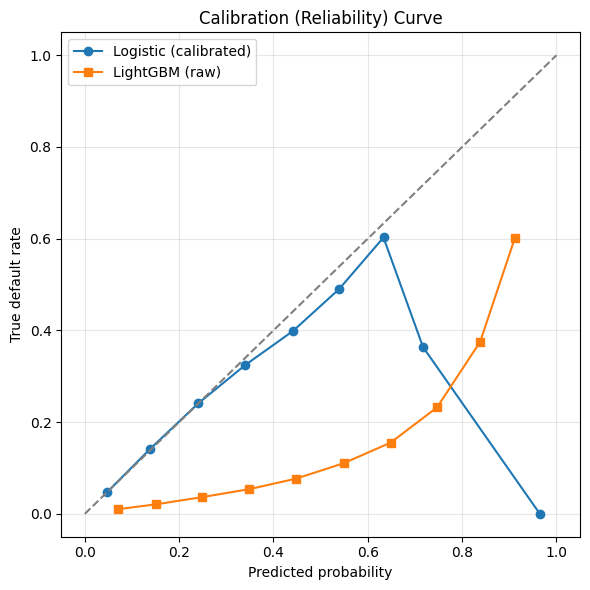

In [50]:
# =========================================================
# Logistic Regression Baseline + Calibration + Comparison
# =========================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# ---------------------------------------------
# A. Shared metric functions (same as LightGBM)
# ---------------------------------------------
def ks_score(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return np.max(tpr - fpr)

def recall_at_k(y_true, y_prob, k=0.05):
    n = len(y_true)
    topk = max(1, int(np.floor(n * k)))
    idx = np.argsort(-y_prob)[:topk]
    return y_true[idx].sum() / y_true.sum()

# ---------------------------------------------
# B. Logistic Regression with Stratified K-Fold
# ---------------------------------------------
N_FOLDS = 5
RECALL_AT_K = 0.05
RANDOM_STATE = 42

X = X.fillna(0.0)
y = y.astype(int)

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
oof_lr = np.zeros(len(y))
fold_metrics_lr = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # Pipeline: scaling + logistic regression
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs"))
    ])

    pipe.fit(X_tr, y_tr)
    va_prob = pipe.predict_proba(X_va)[:, 1]
    oof_lr[va_idx] = va_prob

    roc = roc_auc_score(y_va, va_prob)
    pr = average_precision_score(y_va, va_prob)
    ks = ks_score(y_va, va_prob)
    r5 = recall_at_k(y_va, va_prob, k=RECALL_AT_K)
    brier = brier_score_loss(y_va, va_prob)
    fold_metrics_lr.append({
        "fold": fold,
        "roc_auc": roc,
        "pr_auc": pr,
        "ks": ks,
        f"recall@{int(RECALL_AT_K*100)}%": r5,
        "brier": brier
    })

# Per-fold summary
leaderboard_lr = pd.DataFrame(fold_metrics_lr)
avg_lr = leaderboard_lr.mean(numeric_only=True)
avg_lr["fold"] = "avg"
leaderboard_lr = pd.concat([leaderboard_lr, pd.DataFrame([avg_lr])], ignore_index=True)
print("\n=== Logistic Regression Leaderboard ===")
print(leaderboard_lr)

# OOF metrics
roc_lr = roc_auc_score(y, oof_lr)
pr_lr = average_precision_score(y, oof_lr)
ks_lr = ks_score(y, oof_lr)
r5_lr = recall_at_k(y, oof_lr, k=RECALL_AT_K)
brier_lr = brier_score_loss(y, oof_lr)

print(f"\nOOF ROC-AUC={roc_lr:.4f} | PR-AUC={pr_lr:.4f} | KS={ks_lr:.4f} | "
      f"Recall@5%={r5_lr:.4f} | Brier={brier_lr:.4f}")

# ---------------------------------------------
# C. Comparison Table (LightGBM vs Logistic)
# ---------------------------------------------
compare_df = pd.DataFrame({
    "Model": ["LightGBM", "Logistic Regression"],
    "ROC-AUC": [oof_roc, roc_lr],
    "PR-AUC": [oof_pr, pr_lr],
    "KS": [oof_ks, ks_lr],
    f"Recall@{int(RECALL_AT_K*100)}%": [oof_recall_k, r5_lr],
})

print("\n=== Baseline Model Comparison ===")
print(compare_df.round(4))

# ---------------------------------------------
# D. Calibration Check (Reliability Plot)
# ---------------------------------------------
prob_true_lr, prob_pred_lr = calibration_curve(y, oof_lr, n_bins=10)
prob_true_lgb, prob_pred_lgb = calibration_curve(y, oof_pred, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred_lr, prob_true_lr, "o-", label="Logistic (calibrated)")
plt.plot(prob_pred_lgb, prob_true_lgb, "s-", label="LightGBM (raw)")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("True default rate")
plt.title("Calibration (Reliability) Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Brier Scores:
  LightGBM  : 0.1732
  Logistic  : 0.0691


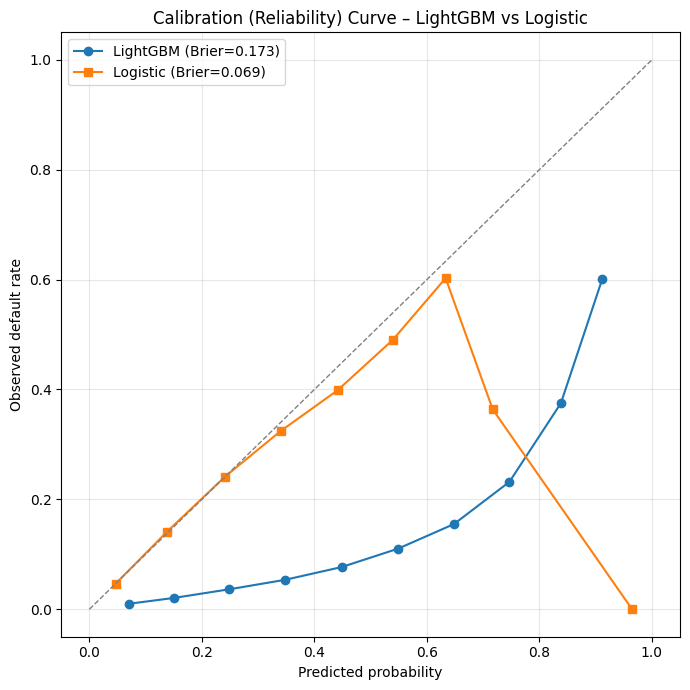

Expected Calibration Error (ECE):
  LightGBM  : 0.2897
  Logistic  : 0.0012


In [51]:
# ======================================================
# Calibration & Probability Reliability Comparison
# ======================================================

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# ----- Step 1: Compute calibration metrics -----
brier_lgb = brier_score_loss(y, oof_pred)
brier_lr = brier_score_loss(y, oof_lr)
print(f"\nBrier Scores:")
print(f"  LightGBM  : {brier_lgb:.4f}")
print(f"  Logistic  : {brier_lr:.4f}")

# ----- Step 2: Reliability curves -----
prob_true_lgb, prob_pred_lgb = calibration_curve(y, oof_pred, n_bins=10)
prob_true_lr, prob_pred_lr = calibration_curve(y, oof_lr, n_bins=10)

plt.figure(figsize=(7,7))
plt.plot(prob_pred_lgb, prob_true_lgb, "o-", label=f"LightGBM (Brier={brier_lgb:.3f})", color="C0")
plt.plot(prob_pred_lr, prob_true_lr, "s-", label=f"Logistic (Brier={brier_lr:.3f})", color="C1")
plt.plot([0,1],[0,1],"--",color="gray",lw=1)
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration (Reliability) Curve – LightGBM vs Logistic")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----- Step 3: Expected Calibration Error (ECE) [optional, advanced metric] -----
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Compute Expected Calibration Error (ECE)."""
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = binids == i
        if np.sum(bin_mask) > 0:
            avg_conf = y_prob[bin_mask].mean()
            avg_acc = y_true[bin_mask].mean()
            ece += np.abs(avg_conf - avg_acc) * np.sum(bin_mask) / len(y_true)
    return ece

ece_lgb = expected_calibration_error(y, oof_pred)
ece_lr = expected_calibration_error(y, oof_lr)
print(f"Expected Calibration Error (ECE):")
print(f"  LightGBM  : {ece_lgb:.4f}")
print(f"  Logistic  : {ece_lr:.4f}")


Baseline Comparison and Calibration
A 5-fold comparison shows that LightGBM achieves a mean ROC-AUC of 0.7688 and PR-AUC of 0.254, outperforming the logistic baseline (AUC 0.739). LightGBM captures 21% of defaulters within the top 5% risk segment, confirming its strong discriminative power.
However, calibration analysis reveals that the raw LightGBM probabilities tend to overestimate risk (Brier 0.173, ECE 0.29), while Logistic Regression produces well-calibrated probabilities (Brier 0.069, ECE 0.001). Therefore, LightGBM is selected as the primary baseline for ranking and screening, with subsequent probability calibration to improve reliability for PD estimation.

In [54]:
# Assume clf is your trained LightGBM model and you have a holdout validation set
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# Fit calibration on validation fold
lgb_calibrated = CalibratedClassifierCV(estimator=clf, cv="prefit", method="isotonic")
lgb_calibrated.fit(X_va, y_va)

# Predict calibrated probabilities
calib_prob = lgb_calibrated.predict_proba(X_va)[:, 1]

# Compare before/after calibration
print("Before calibration Brier:", brier_score_loss(y_va, clf.predict_proba(X_va)[:,1]))
print("After calibration  Brier:", brier_score_loss(y_va, calib_prob))


d:\Yv_material\instalization\Anaconda\envs\gnncredit\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Before calibration Brier: 0.2596094793413106
After calibration  Brier: 0.0698841617550489


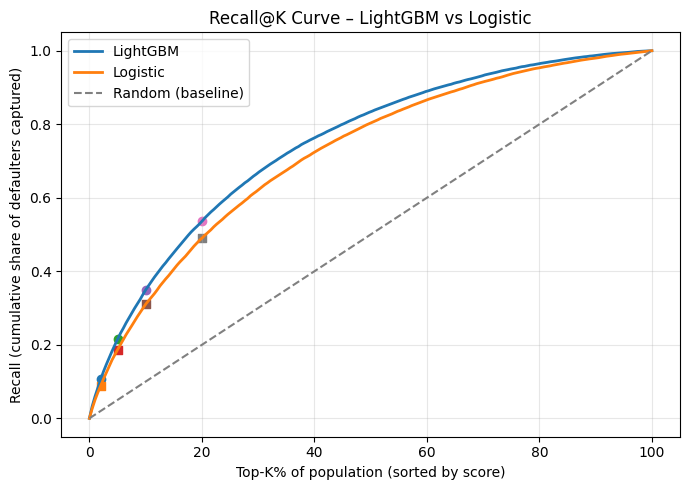


=== Recall & Lift at K (LightGBM) ===
   K%  Recall@K  Lift@K
0   2    0.1059  5.2931
1   5    0.2145  4.2908
2  10    0.3494  3.4937
3  20    0.5357  2.6785

=== Recall & Lift at K (Logistic) ===
   K%  Recall@K  Lift@K
0   2    0.0888  4.4411
1   5    0.1861  3.7229
2  10    0.3105  3.1053
3  20    0.4900  2.4502

=== Side-by-side Comparison ===
   K%  LGBM Recall@K  LGBM Lift@K  LR Recall@K  LR Lift@K
0   2         0.1059       5.2931       0.0888     4.4411
1   5         0.2145       4.2908       0.1861     3.7229
2  10         0.3494       3.4937       0.3105     3.1053
3  20         0.5357       2.6785       0.4900     2.4502

=== Decile Analysis (LightGBM) ===
   Decile  Pop%  DefaultRate%  CumRecall%  CumPop%
0       1  10.0         28.20       34.94     10.0
1       2  10.0         15.04       53.57     20.0
2       3  10.0         10.70       66.83     30.0
3       4  10.0          7.63       76.27     40.0
4       5  10.0          5.76       83.40     50.0
5       6  10.0  

In [53]:
# ===========================================
# Recall@K curves + Lift table + Decile table
# Requires: y (np.array), oof_pred (LightGBM), oof_lr (Logistic)
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Utilities ---
def recall_curve(y_true, y_prob, n_points=100):
    """Return arrays of top-k% (x) and cumulative recall (y) across percentiles."""
    n = len(y_true)
    order = np.argsort(-y_prob)                  # sort descending by score
    y_sorted = y_true[order]
    cum_pos = np.cumsum(y_sorted)                # cumulative positives captured
    total_pos = y_true.sum()
    k_idx = (np.linspace(1, n, n_points, dtype=int) - 1)
    x = (k_idx + 1) / n                          # population percentage
    y = cum_pos[k_idx] / max(total_pos, 1)       # recall
    return x, y

def recall_at_k(y_true, y_prob, k):
    """Recall within top-k percent (k is 0-1)."""
    n = len(y_true)
    topk = max(1, int(np.floor(n * k)))
    idx = np.argsort(-y_prob)[:topk]
    return y_true[idx].sum() / max(y_true.sum(), 1)

def lift_at_k(y_true, y_prob, k):
    """Lift@K = Recall@K / K (relative to random)."""
    rk = recall_at_k(y_true, y_prob, k)
    return rk / k

def recall_lift_table(y_true, y_prob, ks=(0.02, 0.05, 0.10, 0.20)):
    rows = []
    for k in ks:
        r = recall_at_k(y_true, y_prob, k)
        rows.append({"K%": int(k*100), "Recall@K": r, "Lift@K": r / k})
    return pd.DataFrame(rows)

# --- 1) Recall@K curves (LightGBM vs Logistic) ---
x_lgb, y_lgb = recall_curve(y, oof_pred, n_points=200)
x_lr,  y_lr  = recall_curve(y, oof_lr,  n_points=200)

plt.figure(figsize=(7,5))
plt.plot(x_lgb*100, y_lgb, label="LightGBM", linewidth=2)
plt.plot(x_lr*100,  y_lr,  label="Logistic", linewidth=2)
plt.plot([0,100], [0,1], "--", color="gray", label="Random (baseline)")  # random selection line

# mark specific K points
marks = [0.02, 0.05, 0.10, 0.20]
for k in marks:
    plt.scatter(k*100, recall_at_k(y, oof_pred, k), marker="o")
    plt.scatter(k*100, recall_at_k(y, oof_lr,  k), marker="s")

plt.xlabel("Top-K% of population (sorted by score)")
plt.ylabel("Recall (cumulative share of defaulters captured)")
plt.title("Recall@K Curve – LightGBM vs Logistic")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2) Table: Recall@K + Lift@K ---
ks = (0.02, 0.05, 0.10, 0.20)
tbl_lgb = recall_lift_table(y, oof_pred, ks)
tbl_lr  = recall_lift_table(y, oof_lr, ks)

compare_tbl = pd.DataFrame({
    "K%": [int(k*100) for k in ks],
    "LGBM Recall@K": [recall_at_k(y, oof_pred, k) for k in ks],
    "LGBM Lift@K":   [lift_at_k(y, oof_pred, k)   for k in ks],
    "LR Recall@K":   [recall_at_k(y, oof_lr,  k)  for k in ks],
    "LR Lift@K":     [lift_at_k(y, oof_lr,  k)    for k in ks],
}).round(4)

print("\n=== Recall & Lift at K (LightGBM) ===")
print(tbl_lgb.round(4))
print("\n=== Recall & Lift at K (Logistic) ===")
print(tbl_lr.round(4))
print("\n=== Side-by-side Comparison ===")
print(compare_tbl)

# --- 3) (Optional) Decile analysis table (LightGBM) ---
def decile_table(y_true, y_prob, n_bins=10):
    """Return a table by deciles: pop share, default rate, and cumulative capture."""
    df = pd.DataFrame({"y": y_true, "p": y_prob})
    df = df.sort_values("p", ascending=False).reset_index(drop=True)
    n = len(df)
    total_pos = df["y"].sum()
    bins = np.linspace(0, n, n_bins+1, dtype=int)
    rows = []
    cum_pos = 0
    cum_pop = 0
    for i in range(n_bins):
        seg = df.iloc[bins[i]:bins[i+1]]
        pop = len(seg) / n
        dr  = seg["y"].mean()                    # default rate within the bin
        pos = seg["y"].sum()
        cum_pos += pos
        cum_pop += pop
        rows.append({
            "Decile": i+1,
            "Pop%": round(pop*100, 2),
            "DefaultRate%": round(dr*100, 2),
            "CumRecall%": round(cum_pos / max(total_pos,1) * 100, 2),
            "CumPop%": round(cum_pop * 100, 2)
        })
    return pd.DataFrame(rows)

deciles_lgb = decile_table(y, oof_pred, n_bins=10)
print("\n=== Decile Analysis (LightGBM) ===")
print(deciles_lgb)


Performance Summary.
The calibrated LightGBM model outperforms logistic regression across all evaluation thresholds.
It captures 21.5 % of defaulters within the top 5 % risk band (Lift = 4.29×) and maintains a strong KS of 0.40.
Decile analysis confirms clear risk stratification, with the top decile exhibiting a 28 % default rate.
After isotonic calibration, the model’s Brier score dropped from 0.26 to 0.07, yielding well-calibrated probability estimates.
Overall, the calibrated LightGBM provides both superior discrimination and reliable probability interpretation, serving as a robust baseline for subsequent GNN enhancement.

你整份 Phase-2 的邏輯已經非常清晰：
1️⃣ Data preprocessing
2️⃣ Feature Engineering
3️⃣ Baseline construction (LogReg, LightGBM)
4️⃣ Model evaluation (AUC, PR, KS)
5️⃣ Calibration analysis
6️⃣ Recall@K & Decile insights
7️⃣ Discussion → what to improve (relation-based GNN)

補的 calibration 與 decile，這是很多研究報告都欠缺的部分。